In [64]:
import numpy as np
import random
import os
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm import tqdm
import time
from PIL import Image

from setup_networks import network_from_txt, network_indices, Network, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation, area_penalty, cost
from phase_diagrams import get_sinks, remove_edges, make_ellipse_netw, remove_edges, netw_to_nx

In [163]:
insertion_pts = {'P47': 383,
                 'P49': 307,
                 'P51': 92,
                 'P52': 86,
                 'P54': 148}

In [182]:
filepath = '../../../../Desktop/Placenta_Segmentation/LisaIlastik/'
# filepath = '../../../../Downloads/'
placenta = 'P47'

nodes_info = np.genfromtxt(filepath + placenta + '_graph_nodes.csv', skip_header=1, delimiter=',', dtype=None, encoding='utf8')
edge_info = np.genfromtxt(filepath + placenta + '_graph_edges.csv', skip_header=1, delimiter=',', dtype=None, encoding='utf8')
# insertion_pt = np.array([1172., 1190.])

# NOTE: when computing path lengths, I skip the first element of the path (which is the arbitrary element I'm adding now)
# cutoff_ind = 0#11 #Add edges between the insertion point and the cutoff_ind closest nodes to the insertion point
K_prefactor = 0.3

nodes = []
for n in range(len(nodes_info)):
    node_ind = nodes_info[n][0]
    node_x = np.array(nodes_info[n][1], dtype=float)
    node_y = np.array(nodes_info[n][2], dtype=float)
    node_pos = np.array([node_x, node_y])    
    nodes += [node_pos]

# nodes += [insertion_pt]
nodes = np.array(nodes)
node_dists = np.linalg.norm(nodes - insertion_pt, axis=1)
connect_to_insertion = list(np.argsort(node_dists)[1:cutoff_ind+1])


edges = []
K = []
lengths = []
for e in range(len(edge_info)):
    e_start = edge_info[e][0]
    e_end = edge_info[e][1]
    width = edge_info[e][3]
    if e_start != e_end:

        # # Connect to insertion point if within cutoff
        # start_to_insertion = np.linalg.norm(nodes[e_start] - insertion_pt)
        # end_to_insertion = np.linalg.norm(nodes[e_end] - insertion_pt)
        # if start_to_insertion < cutoff:
        #     if end_to_insertion < start_to_insertion:
        #         edges += [[e_end, len(nodes)-1]]
        #         lengths += [end_to_insertion]
        #         K += [K_prefactor * width**4] # assume same width as nearby edge
        #     else:
        #         edges += [[e_start, len(nodes)-1]]   
        #         lengths += [start_to_insertion]
        #         K += [K_prefactor * width**4] # assume same width as nearby edge       
        
        edges += [[e_start, e_end]]
        K += [K_prefactor * width**4]
        lengths += [edge_info[e][2]]


if placenta == 'P51':
    edges += [[69, 42]]
    K += [K[68]]
    lengths += [np.linalg.norm(nodes[69] - nodes[42])]
        
# insertion_node_ID = len(nodes) - 1
# for n in connect_to_insertion:
#     edges += [[insertion_node_ID, n]]
#     K += [np.mean(K)]
#     lengths += [node_dists[n]]


edges = np.array(edges)
K = np.array(K, dtype=float)
lengths = np.array(lengths, dtype=float)



G = nx.Graph()
weighted_edges_K = np.append(edges, 1/K[:, np.newaxis], 1)
weighted_edges_len = np.append(edges, lengths[:, np.newaxis], 1)
G.add_nodes_from(np.arange(len(nodes)))
G.add_weighted_edges_from(weighted_edges_K, weight='K')
G.add_weighted_edges_from(weighted_edges_K, weight='lengths')

largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()


G_ = nx.minimum_spanning_tree(largest_cc, weight='K')
new_K = np.array([1/v for v in nx.get_edge_attributes(G_, 'K').values()])
new_lengths = np.array([v for v in nx.get_edge_attributes(G_, 'lengths').values()])
new_edges = np.array([[e[0], e[1]] for e in G_.edges], dtype=int)


# new_nodes = np.unique(new_edges.flatten())
# new_nodepos = nodes[new_nodes]

netw = network_from_edges_and_nodes(new_edges, nodes)
netw.lengths = new_lengths
K = new_K


# netw = network_from_edges_and_nodes(edges, nodes)
# netw.lengths = lengths

(-0.5, 1969.5, -0.5, 1969.5)

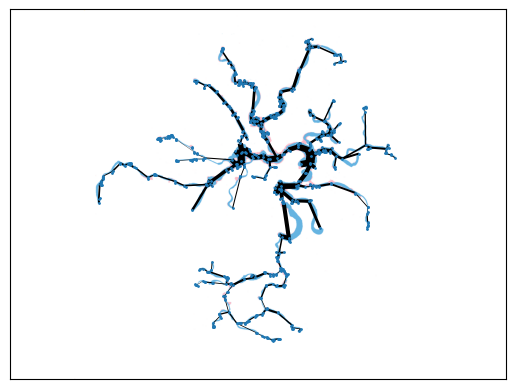

In [184]:
G = nx.Graph()
G.add_nodes_from(np.arange(len(netw.pos)))
G.add_edges_from(netw.edgelist)

imgpath = '../../../../Desktop/Placenta_Segmentation/'
img = Image.open(imgpath + placenta + '_manual.tif')
img = np.array(img)
img = np.fliplr(img)
# img = np.rot90(img)
plt.imshow(img, cmap='gray', alpha=0.6, origin='lower')

sizes = np.ones(len(nodes)) * 5.
sizes[-1] = 100.

# width=K**(1/4)
# pos = nodes + np.array([0., 1960.])
# plt.scatter(1328, 1140, s=200, color='orange')
# plt.scatter(*netw.pos[148], s=150, color='green')
nx.draw_networkx(G, pos=netw.pos, width=0.3 * K**(1/4), with_labels=False, node_size=1)
plt.axis('equal')

# Length metric

## Analysis functions

In [172]:
def netw_to_nx(netw, K, lengths):
    G = nx.Graph()
    #weighted_edges = np.append(netw.edgelist, 1/K[:, np.newaxis], 1)
    weighted_edges = np.append(netw.edgelist, lengths[:, np.newaxis]/K[:, np.newaxis], 1)
    G.add_nodes_from(np.arange(len(netw.pos)))
    G.add_weighted_edges_from(weighted_edges, weight='K')
    return G




'''
Given a Network object and a ratio of the two ellipse axes (1.0 if circle), returns
the square root of the area of the network.
'''
def sqrt_area_of_network(netw, ellipse_ratio):
    inds = network_indices(netw)
    left_idx = inds['left']
    dist_fn = lambda x: np.linalg.norm(x[left_idx] - x, axis=1)
    dists = dist_fn(netw.pos)
    long_axis = np.max(dists) / 2
    short_axis = long_axis*ellipse_ratio
    return np.sqrt(np.pi * long_axis * short_axis)

'''
Arguments:
    - netw: Network object
    - K: list of conductances for each edge in the network
    - insertion_point: string ('center' or 'left') indicating the position of the source in the network
Returns: 
    - unweighted_path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes
    - path_length: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in the number of nodes and paths are weighted by 1/conductance
    - path_weight: list of lengths of shortest paths from the source to each branch point in the network, 
        where the length is measured in 1/conductance and paths are weighted by 1/conductance
'''
def distance_insertion_to_branch_points(netw, K, insertion_point=None):
    # clipped_netw, clipped_K = remove_edges(netw, K)
    # G = netw_to_nx(clipped_netw, clipped_K)
    G = netw_to_nx(netw, K, netw.lengths)

    if insertion_point is not None:
        # inds = network_indices(netw)
        # source = inds[insertion_point]
        source = insertion_point
    else:
        source = len(nodes) - 1
    
    degrees = np.array(list(G.degree))
    branch_points = np.where(degrees[:, 1] > 2)[0]
    boundary_nodes = np.where(degrees[:, 1] == 1)[0]
    branches = np.concatenate([branch_points, boundary_nodes])
    
    unweighted_path_length = []
    path_length = []
    path_weight = []
    for b in branches:
        path = nx.dijkstra_path(G, source, b, weight='K')
        # if insertion_point is None: # if experimental, skip the first weight
            # path = path[1:]
        pathweight = nx.path_weight(G, path, weight='K')
        path_unweighted = nx.dijkstra_path(G, source, b, weight=1.)
        
        path_length += [len(path)-1] #subtract 1 to get number of edges rather than number of nodes in path
        unweighted_path_length += [len(path_unweighted) - 1]
        path_weight += [pathweight]
        
        
    return np.array(unweighted_path_length, dtype=float), np.array(path_length, dtype=float), np.array(path_weight, dtype=float)


## Results

In [173]:
unweighted_path_lengths, path_lengths, path_weights = distance_insertion_to_branch_points(netw, K, insertion_point=insertion_pts[placenta])
# normalize the lengths 
# path_lengths *= edge_len #/ sqrt_area

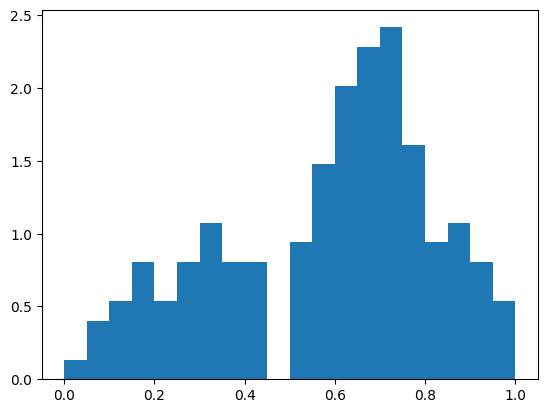

In [174]:
plt.hist(path_lengths / np.max(path_lengths), density=True, bins=20);

# Coverage metric

## Analysis functions

In [175]:
from scipy.ndimage import distance_transform_edt
from PIL import Image


def save_png(netw, K, filename):

    xmin = np.min(netw.pos[:,0])
    xmax = np.max(netw.pos[:,0])
    ymin = np.min(netw.pos[:,1])
    ymax = np.max(netw.pos[:,1])
    
    new_netw, new_K = remove_edges(netw, K)
    
    #inds = network_indices(new_netw)
    #insertion_point = inds[insertion_point_str]
    plt.figure(figsize=(7,7))
    
    G = nx.Graph()
    node_pos = new_netw.pos
    node_dict = {}
    for n in np.arange(len(node_pos)):
        node_dict[n] = node_pos[n]
    
    edges = new_netw.edgelist
    G.add_nodes_from(np.arange(len(node_pos)))
    G.add_edges_from(edges)
    
    nx.draw_networkx(G, pos=node_dict, width=4 * new_K**0.25, with_labels=False, node_size=0);
    plt.axis('equal')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.axis('off')
    plt.savefig(filename, format='png')
    plt.close()

## Results

In [176]:
img_filename = placenta + '_netw.png'
save_png(netw, K, img_filename)

image = Image.open(img_filename)
image_array = np.array(image)
dists = distance_transform_edt(image_array).flatten()

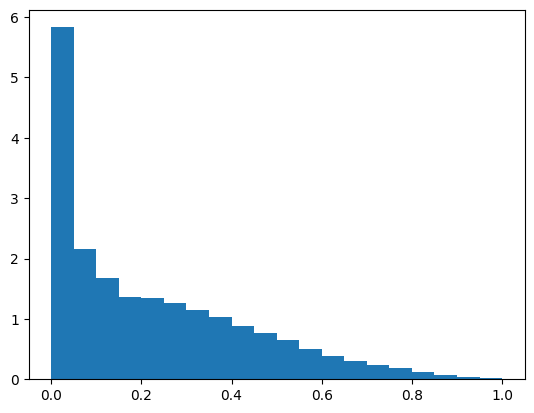

In [177]:
plt.hist(dists / np.max(dists), bins=20, density=True);

# Subtree size metric

## Analysis functions

In [178]:
def make_directed_edges(netw, insertion_point=None):
    if insertion_point is not None:
        if isinstance(insertion_point, str):
            inds = network_indices(netw)
            source = inds[insertion_point]
        else:
            source = insertion_point
    else:
        source = len(netw.pos) - 1

    G = nx.Graph()
    nodes = np.arange(len(netw.pos))
    G.add_nodes_from(nodes)
    G.add_edges_from(netw.edgelist)
    
    directed_edgelist = []
    
    for e in netw.edgelist:
        n1, n2 = e
        path_n1 = nx.dijkstra_path(G, source, n1)
        path_n2 = nx.dijkstra_path(G, source, n2)
    
        if path_n1 > path_n2:
            directed_edgelist += [[n2, n1]]
        else:
            directed_edgelist += [[n1, n2]]

    return directed_edgelist


def get_subtree_sizes(netw, K, insertion_point=None, remove_extra_edges=True):
    if remove_extra_edges:
        netw, K = remove_edges(netw, K)
        
    directed_edgelist = make_directed_edges(netw, insertion_point=insertion_point)
    
    G = nx.DiGraph()
    nodes = np.arange(len(netw.pos))
    G.add_nodes_from(nodes)
    G.add_edges_from(directed_edgelist)
    
    degrees = np.array(list(G.degree))
    branch_points = np.where(degrees[:, 1] > 2)[0]
    boundary_nodes =  np.where(degrees[:, 1] == 1)[0]

    subtree_sizes = []
    for b in branch_points:
        subtree_size = 0
        for n in boundary_nodes:
            try:
                path = nx.dijkstra_path(G, b, n)
                #print(len(path))
                subtree_size += 1
            except:
                #print('No path')
                continue;
        subtree_sizes += [subtree_size]

    return np.array(subtree_sizes)

## Results

In [180]:
subtrees = get_subtree_sizes(netw, K, remove_extra_edges=False, insertion_point=insertion_pts[placenta])#224)
# subtrees = get_subtree_sizes(netw, K)

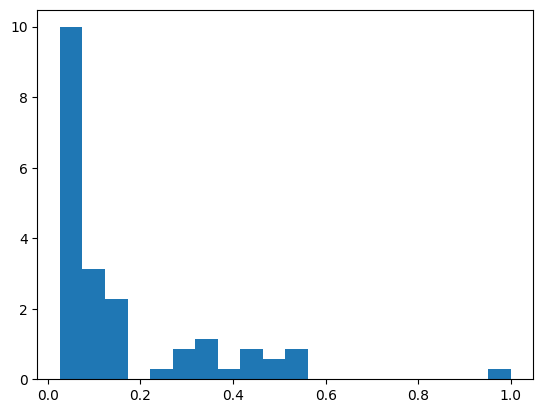

In [181]:
plt.hist(subtrees/np.max(subtrees), bins=20, density=True);

# Analyze raw images

In [654]:
def remove_stripe(image_path,output_path):
    # Open the image and convert to a numpy array
    image = Image.open(image_path)
    image_array = np.array(image, dtype=np.uint16)


    number_nonblank_pixels_hor = (image_array>0).sum(0)
    number_nonblank_pixels_ver = (image_array>0).sum(1)
    keep_hor = np.where(number_nonblank_pixels_hor>0)[0]
    keep_ver = np.where(number_nonblank_pixels_ver>0)[0]

    # Remove the stripe from the horizontal and vertical edges starting at pixel j
    cropped_image_array = image_array[keep_hor, :]
    cropped_image_array = cropped_image_array[:,keep_ver]

    # Convert the cropped numpy array back to an image
    cropped_image = Image.fromarray(cropped_image_array)

    # Save the cropped image
    cropped_image.save(output_path)

# Example usage
folder_path = '../../../../Desktop/Placenta_Segmentation/'

input_image_path = folder_path +'MAX_base47_16bit.tif'  # Replace with your image path
output_image_path = folder_path +'output_MAX_base47_16bit.tif'  # Replace with your output path


remove_stripe(input_image_path, output_image_path)

In [681]:
# Node IDs for insertion points

P47_insertion_pt = 224
P54_insertion_pt = 131 # Lisa's guess is 78 - check!!

In [677]:
# Skeletonize and get nodes, edges

from skimage.morphology import skeletonize
from skimage import data
import sknw

# open and skeletonize
imgpath = '../../../../Desktop/Placenta_Segmentation/'
img = Image.open(imgpath + 'P54_manual.tif')
img = np.array(img)
ske = skeletonize(~img).astype(np.uint16)

# build graph from skeleton
graph = sknw.build_sknw(ske)

In [678]:
# Convert to netw format, remove loops and spurious nodes

nodes = graph.nodes()
nodepos = []
for i in range(len(nodes)):
    nodepos += [[nodes[i]['o'][1], nodes[i]['o'][0]]]
nodepos = np.array(nodepos)#[:, :-1] #np.array([nodes[i]['o'] for i in nodes])[:, :-1]
edges = []

for (s,e) in graph.edges():
    edges += [[s, e]]

exp_netw_ = network_from_edges_and_nodes(edges, nodepos)
G = nx.Graph()
G.add_nodes_from(np.arange(len(exp_netw_.pos)))
G.add_edges_from(exp_netw_.edgelist)

G_ = nx.minimum_spanning_tree(G)
largest_cc = G.subgraph(max(nx.connected_components(G_), key=len)).copy()

new_edges = []
new_nodes = []
new_nodepos = []
i = 0
for e in largest_cc.edges():
    if e[0] != e[1]:
       new_edges += [[e[0], e[1]]]

new_edges = np.array(new_edges, dtype=int)
new_nodes = np.unique(new_edges.flatten())
new_nodepos = nodepos[new_nodes]

mapping = {new_nodes[n]: n for n in range(len(new_nodes))}

new_edges_mapped = []
new_nodes_mapped = np.arange(len(new_nodes))

for e in new_edges:
    new_edges_mapped += [[mapping[e[0]], mapping[e[1]]]]


G = nx.Graph()
G.add_nodes_from(new_nodes_mapped)
G.add_edges_from(new_edges_mapped)
G_ = nx.minimum_spanning_tree(G)
edges = np.array([[e[0], e[1]] for e in G_.edges], dtype=int)

exp_netw = network_from_edges_and_nodes(edges, new_nodepos)

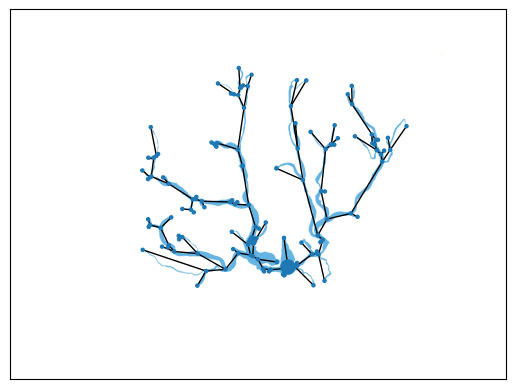

In [703]:
plt.imshow(img, cmap='gray', alpha=0.6)

G = nx.Graph()
G.add_nodes_from(np.arange(len(exp_netw.pos)))
G.add_edges_from(exp_netw.edgelist)

sizes = np.ones(len(exp_netw.pos)) * 5.
sizes[131] = 100.
# plt.scatter(1128, 1360, s=100)
# plt.scatter(mn[0], mn[1], s=100)

nx.draw_networkx(G, pos=exp_netw.pos, width=1., with_labels=False, node_size=sizes)
plt.axis('equal')
plt.show()

In [701]:
# mn = np.array([1120, 1150]) #47
# mn = np.array([1328, 1140]) #54 Lisa
mn = np.array([1128, 1360]) #54 Ella

In [702]:
np.argmin(np.linalg.norm(exp_netw.pos - mn, axis=1))

131

In [662]:
np.max(exp_netw.pos)

1776

In [663]:
np.min(exp_netw.pos)

312

In [10]:
from jax import random

In [20]:
key = random.PRNGKey(1)
random.normal(random.split(key, 2)[0], (2,))

Array([-0.27703857,  1.351606  ], dtype=float32)